# Replicating _Intermediary asset pricing: New evidence from many asset classes_

### James, Young Jin Song, Jaehwa Youm, Monica Panigrahy, and Jacob Simeral

In [1]:
import load_nyfed
load_nyfed.pull_nyfed_primary_dealers_list(load_nyfed.url)

import pandas as pd
import wrds
import config
from datetime import datetime
import unittest
import matplotlib.pyplot as plt
import numpy as np
import Table02Analysis
import Table02Prep

import Table03Load
import Table03Analysis
import Table03

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

File saved to cache at /Users/zoer/Documents/FullStack/Final-Project-32900-2/my_data/pulled/nyfed_primary_dealers_list.xls.


### Table 02

The following code reads in a manual data file that contains necessary information on primary dealers from 1960-2012 and then merges it with the CRSP Compustat Merge Linkhist table to get additional information on each, such as the SIC codes. The linkhist table is also used as the main reference table to pull the other comparison groups for the table.

In [11]:
db = wrds.Connection(wrds_username=config.WRDS_USERNAME)

Loading library list...
Done


In [7]:
# prim_dealers, link_hist = Table02Prep.prim_deal_merge_manual_data_w_linktable()
# prim_dealers

In [6]:
# link_hist

In [27]:
import importlib
importlib.reload(Table02Prep)
importlib.reload(config)

<module 'config' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/config.py'>

In [26]:
prim_dealers = Table02Prep.clean_primary_dealers_data(fname='Primary_Dealer_Link_Table3.csv')
link_hist = Table02Prep.load_link_table(fname='updated_linktable.csv')

As mentioned above, the next step is now to use the linkhist table to determine what the other comparison groups are. We use SIC codes to determine broker dealers and banks, and we make sure to exclude any firms that are already in the primary dealer group so we do not have duplicates. Below is the reference table for broker dealers, which had explicit SIC codes mentioned in the paper - banks did not have explicit SIC codes mentioned and required research.

In [28]:
comparison_group_link_dict = Table02Prep.create_comparison_group_linktables(link_hist, prim_dealers)
comparison_group_link_dict['PD']

,Primary Dealer,gvkey,Start Date,End Date
1,BANKERS TRUST,2029,05/19/1960,07/07/1989
4,CHEMICAL,15197,05/19/1960,03/31/1989
7,DISCOUNT CORPORATION OF NEW YORK,3689,05/19/1960,08/10/1993
9,FIRST CHICAGO,4689,05/19/1960,01/01/1990
10,"IRVING SECURITIES, INC.",6186,05/19/1960,07/31/1989
...,...,...,...,...
162,MORGAN STANLEY & CO. LLC,12124,05/31/2011,Current
163,"BANK OF NOVA SCOTIA, NEW YORK AGENCY",15582,10/04/2011,Current
164,BMO CAPITAL MARKETS CORP.,15580,10/04/2011,Current
165,JEFFERIES LLC,6239,03/01/2013,Current


We then used each of the reference tables (primary dealers, broker dealers, banks, all firms in Compustat) and pulled data from the Compustat Fundamentals Quarterly table. The paper mentioned use of monthly data, but there was no apparent monthly table for financial statement data from Compustat. This led to some confusion about how these authors generated their ratios - I am wondering if they computed monthly ratios given what months came out of annual and then took the average.

Below is the dataset for broker dealers. We calculate or directly pull the values we need in our query so we don't need to do it after. It was mentioned in class this was a best practice because it would run on WRDS servers.

In [29]:
datasets = Table02Prep.pull_data_for_all_comparison_groups(db, comparison_group_link_dict)
datasets['BD']

,datadate,total_assets,book_debt,book_equity,market_equity,gvkey,conm
0,1970-04-30,NaN,NaN,NaN,NaN,001967,BACHE GROUP INC
1,1970-07-31,NaN,NaN,NaN,NaN,001967,BACHE GROUP INC
2,1970-10-31,NaN,NaN,NaN,NaN,001967,BACHE GROUP INC
3,1971-01-31,NaN,NaN,48.978,NaN,001967,BACHE GROUP INC
4,1971-04-30,NaN,NaN,NaN,NaN,001967,BACHE GROUP INC
...,...,...,...,...,...,...,...
5726,2007-06-30,2843.526,2589.891,NaN,NaN,209386,VAN DER MOOLEN NV
5727,2007-09-30,3903.258,3650.586,NaN,NaN,209386,VAN DER MOOLEN NV
5728,2007-12-31,1525.721,1352.675,173.046,186.570500,209386,VAN DER MOOLEN NV
5729,2008-03-31,3147.092,2984.300,NaN,193.259735,209386,VAN DER MOOLEN NV


We then prep that data further by aggregating by year and standardizing the date to the first of the year. We also convert the datadate to a datetime column that can be sliced.

In [13]:
prepped_datasets = Table02Prep.prep_datasets(datasets)
prepped_datasets['Banks']

,datadate,total_assets,book_debt,book_equity,market_equity
0,1961-10-01,5.587481e+03,1.319469e+04,9.922428e+02,2.549623e+03
1,1962-01-01,1.655581e+05,4.117659e+05,1.239516e+04,1.863324e+04
2,1962-04-01,1.292619e+05,4.120670e+05,9.878578e+03,1.647359e+04
3,1962-07-01,1.673161e+05,4.121743e+05,1.246343e+04,1.715841e+04
4,1962-10-01,8.402504e+04,4.131878e+05,6.529664e+03,1.487552e+04
...,...,...,...,...,...
200,2011-10-01,1.398707e+07,1.287203e+07,1.097745e+06,9.083609e+05
201,2012-01-01,1.563182e+07,1.442009e+07,1.207936e+06,1.192410e+06
202,2012-04-01,1.448400e+07,1.331260e+07,1.144779e+06,1.083143e+06
203,2012-07-01,1.577701e+07,1.451733e+07,1.232051e+06,1.189400e+06


We then weave in some of our analysis into the process, whenever the necessary dataset for the analysis is first available. Below is our main table of ratios, where we have computed the
$$
\frac{\text{Primary dealers amount}}{\text{Comparison group amount (less PD) + Primary dealers amount}}
$$

In [14]:
Table02Analysis.create_summary_stat_table_for_data(datasets)
table = Table02Prep.create_ratios_for_table(prepped_datasets)
table

Summary stats LaTeX saved to: /Users/zoer/Documents/FullStack/Final-Project-32900-2/my_output/table02_sstable.tex


,total_assets_BD,book_debt_BD,book_equity_BD,market_equity_BD,total_assets_Banks,book_debt_Banks,book_equity_Banks,market_equity_Banks,total_assets_Cmpust.,book_debt_Cmpust.,book_equity_Cmpust.,market_equity_Cmpust.,Period
datadate,,,,,,,,,,,,,
1962-01-01,NaN,NaN,NaN,NaN,0.060315,0.604048,0.069671,0.079119,0.005286,0.284311,0.002226,0.001763,1960-2012
1962-04-01,NaN,NaN,NaN,NaN,0.078854,0.603895,0.086840,0.066258,0.005316,0.278020,0.002189,0.001259,1960-2012
1962-07-01,NaN,NaN,NaN,NaN,0.060072,0.603769,0.070923,0.070998,0.005095,0.275824,0.002185,0.001396,1960-2012
1962-10-01,NaN,NaN,NaN,NaN,0.124270,0.603371,0.128363,0.088469,0.005603,0.273467,0.002200,0.001522,1960-2012
1963-01-01,NaN,NaN,NaN,NaN,0.079982,0.602639,0.087932,0.083158,0.005195,0.265228,0.002120,0.001525,1960-2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-10-01,0.987924,0.989000,0.973898,0.952674,0.633434,0.638124,0.560122,0.481265,0.279310,0.319786,0.091432,0.033016,1990-2012
2012-01-01,0.984463,0.985631,0.970987,0.954790,0.564276,0.567777,0.506864,0.474662,0.244451,0.281020,0.081882,0.039249,1990-2012
2012-04-01,0.987413,0.988427,0.970975,0.954785,0.629719,0.634657,0.556629,0.463797,0.277035,0.318208,0.090506,0.034570,1990-2012


We create a figure that can give the reader insight into how the ratios have shifted over time for each category and comparison group. We had to clean some of the data and fill null values to have the graph look reasonable but without changing the overall shape of it too dramatically.
Lastly, we get our final table which was what we were trying to replicate from the paper. This table is then converted to LaTeX and outputted to a .tex file.

In [15]:
formatted_table = Table02Prep.format_final_table(table)
formatted_table

Metric    Total assets                     Book debt                      \
Source              BD     Banks   Cmpust.        BD     Banks   Cmpust.   
Period                                                                     
1960-2012     0.901390  0.401558  0.124282  0.911984  0.439667  0.172128   
1960-1990     0.893790  0.352351  0.084319  0.912629  0.414210  0.145087   
1990-2012     0.909973  0.457565  0.174741  0.910400  0.464265  0.205330   

Metric    Book equity                     Market equity                      
Source             BD     Banks   Cmpust.            BD     Banks   Cmpust.  
Period                                                                       
1960-2012    0.890513  0.316582  0.030400      0.866325  0.284491  0.017393  
1960-1990    0.876942  0.271433  0.017615      0.834360  0.232131  0.009452  
1990-2012    0.907863  0.369296  0.046663      0.903828  0.349448  0.027207

In [30]:
updated_table = Table02Prep.main(UPDATED=True)
updated_table

Loading library list...
Done
Summary stats LaTeX saved to: /Users/zoer/Documents/FullStack/Final-Project-32900-2/my_output/updated_table02_sstable.tex
Figure saved to: /Users/zoer/Documents/FullStack/Final-Project-32900-2/my_output/updated_table02_figure.png
Correlation matrix LaTeX saved to: /Users/zoer/Documents/FullStack/Final-Project-32900-2/my_output/updated_table02_corr.tex
Table 02 LaTeX saved to: /Users/zoer/Documents/FullStack/Final-Project-32900-2/my_output/updated_table02.tex


Metric    Total assets                     Book debt                      \
Source              BD     Banks   Cmpust.        BD     Banks   Cmpust.   
Period                                                                     
1960-2025     0.926832  0.468270  0.158808  0.936573  0.502374  0.207305   
1960-1990     0.903412  0.394905  0.098691  0.924753  0.462422  0.164489   
1990-2025     0.944883  0.523915  0.208462  0.945373  0.529491  0.242054   

Metric    Book equity                     Market equity                      
Source             BD     Banks   Cmpust.            BD     Banks   Cmpust.  
Period                                                                       
1960-2025    0.912377  0.391158  0.047326      0.877963  0.359332  0.022217  
1960-1990    0.878194  0.309989  0.024376      0.823649  0.268974  0.010866  
1990-2025    0.939848  0.454378  0.066337      0.919985  0.433399  0.031427

### Table 03

#### 3.1 Pull the quarterly dataset for primary dealers
- Start with the merged data for primary dealers from 'Table02.prim_deal_merge_manual_data_w_linktable'. The resulting dataframe 'prim_dealers' contains the list of gvkey, starting dates, and ending dates for the primary dealers during 1960-2012. 
- Use the 'fetch_data_for_tickers' function to retrieve the financial data (assets, liabilities, equity(market and book), etc.) for the tickers associated with the primary dealers from the WRDS database. The pulled items are total assets, book debt and equity, and market equity, which are needed for the calculation of market and book capital ratios.

In [48]:
import importlib
importlib.reload(Table03Load)

<module 'Table03Load' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/Table03Load.py'>

In [78]:
db.close()
db = wrds.Connection(wrds_username=config.WRDS_USERNAME)


Loading library list...
Done


In [33]:
# db = wrds.Connection(wrds_username=config.WRDS_USERNAME)
#prim_dealers, _ = Table02Prep.prim_deal_merge_manual_data_w_linktable()
prim_dealers = Table02Prep.clean_primary_dealers_data(fname='Primary_Dealer_Link_Table3.csv')
dataset, _ = Table03Load.fetch_data_for_tickers(prim_dealers, db)    
dataset

,datafqtr,total_assets,book_debt,book_equity,market_equity,gvkey,conm
0,1962Q1,3593.891,3272.463,321.428,560.937226,002029,BANKERS TRUST CORP
1,1962Q2,3682.725,3357.419,325.306,385.924726,002029,BANKERS TRUST CORP
2,1962Q3,3540.791,3210.857,329.934,417.337226,002029,BANKERS TRUST CORP
3,1962Q4,3962.018,3630.878,331.140,494.791246,002029,BANKERS TRUST CORP
4,1963Q1,3890.221,3555.538,334.683,502.599452,002029,BANKERS TRUST CORP
...,...,...,...,...,...,...,...
40,2024Q1,1910892.000,1809310.000,101582.000,144727.407000,015706,TORONTO DOMINION BANK
41,2024Q2,1966668.000,1865189.000,101479.000,143682.031000,015706,TORONTO DOMINION BANK
42,2024Q3,1967181.000,1866493.000,100688.000,142506.287000,015706,TORONTO DOMINION BANK
43,2024Q4,2061751.000,1957479.000,104272.000,134705.197000,015706,TORONTO DOMINION BANK


#### 3.2 Prepare the dealers dataset and macro data 
- The prep_dataset function cleanses the dataset and integrates broker-dealer financial information from Flow of Funds, which is needed for calculating AEM capital ratios. The resulting prep_datast begins from a year before to 1970 for the subsequent factor and growth rate computations.
- The UPDATED parameter controls the source for broker-dealer financial data: False retrieves historical data up to 2012-12-31 from a specific URL, while True  pulls more recent data from FRED.
    - historical data link(Released at 2013 March): https://www.federalreserve.gov/releases/z1/20130307/data.htm     
    - FRED data link: https://fred.stlouisfed.org/series/BOGZ1FL664090005Q

In [52]:
import importlib

importlib.reload(Table03) 

<module 'Table03' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/Table03.py'>

In [34]:
prep_datast = Table03.prep_dataset(dataset, UPDATED=False)
prep_datast

Extracted ltab127d.prn to /Users/zoer/Documents/FullStack/Final-Project-32900-2/my_data/pulled/ltab127d.prn


,datafqtr,total_assets,book_debt,book_equity,market_equity,bd_fin_assets,bd_liabilities
32,1970-03-31,4.701312e+04,4.446352e+04,2549.601,3.703907e+03,13071.0,12285.00
33,1970-06-30,4.685770e+04,4.426275e+04,2594.944,3.079840e+03,11741.0,10996.00
34,1970-09-30,7.146010e+04,6.774211e+04,3717.989,4.818651e+03,13298.0,12576.00
35,1970-12-31,7.348761e+04,6.973037e+04,3757.248,5.081601e+03,16246.0,15509.00
36,1971-03-31,7.571639e+04,7.186551e+04,3850.881,5.562409e+03,14861.0,14097.00
...,...,...,...,...,...,...,...
199,2011-12-31,2.207158e+07,2.079585e+07,1275733.368,8.158459e+05,1949702.0,1870911.00
200,2012-03-31,1.760145e+07,1.648100e+07,1120452.270,9.326383e+05,2063829.0,1978049.00
201,2012-06-30,2.257662e+07,2.126312e+07,1313501.594,8.964198e+05,2052880.0,1967675.00
202,2012-09-30,2.278120e+07,2.143375e+07,1347445.296,9.824928e+05,2048823.0,1957817.00


#### 3.3 Calculate the Capital ratios and factors 
- The 'aggregate_ratios' function calculates the capital ratios - market capital ratio, book capital ratio, and AEM leverage ratio. The ratio formulas are described as below.
- The 'convert_ratios_to_factors' function  transforms the aggregated financial ratios into factors that can be used to analyze their impact on asset prices. The factors are AR(1) innovations to the market-based capital ratio of primary dealers, scaled by the lagged capital ratio.
- The resulting ratio_dataset and factors_dataset begin from a year before to 1970 for the subsequent factor and growth rate computations.

$$
\text{Market Capital Ratio}_t = \frac{\text{Market Equity}_t}{\text{Market Equity}_t + \text{Book Debt}_t}
$$
$$
\text{Book Capital Ratio}_t = \frac{\text{Book Equity}_t}{\text{Book Equity}_t + \text{Book Debt}_t}
$$
$$
\text{Leverage}_t = \frac{\text{Total Financial Assets}_t}{\text{Total Financial Assets}_t - \text{Total Liabilities}_t} \text{,  }
\text{Leverage Implied Capital Ratio}_t = \frac{1}{\text{Leverage}_t}
$$

In [35]:
ratio_dataset = Table03.aggregate_ratios(prep_datast)
ratio_dataset

,market_cap_ratio,book_cap_ratio,aem_leverage
date,,,
1970-03-31,0.076897,0.054232,16.629771
1970-06-30,0.065054,0.055379,15.759732
1970-09-30,0.066409,0.052029,18.418283
1970-12-31,0.067925,0.051128,22.043419
1971-03-31,0.071840,0.050859,19.451571
...,...,...,...
2011-12-31,0.037750,0.057800,24.745237
2012-03-31,0.053558,0.063657,24.059559
2012-06-30,0.040453,0.058180,24.093422


In [189]:
import importlib

importlib.reload(Table03) 

<module 'Table03' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/Table03.py'>

In [36]:
factors_dataset = Table03.convert_ratios_to_factors(ratio_dataset)
factors_dataset

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


,market_capital_factor,book_capital_factor,aem_leverage_factor
date,,,
1970-03-31,NaN,NaN,0.057434
1970-06-30,-0.136391,0.042019,-0.047764
1970-09-30,0.029987,-0.037515,0.149463
1970-12-31,0.033124,-0.000804,0.154064
1971-03-31,0.069122,0.009386,-0.060145
...,...,...,...
2011-12-31,-0.038294,-0.034440,0.059141
2012-03-31,0.388277,0.128520,0.029725
2012-06-30,-0.247280,-0.050003,0.005961


#### 3.4 Process Macroeconomic Indicators
- The 'macro_variables' function fetches and processes macroeconomic indicators such as earnings-to-price ratio, unemployment rate, financial conditions index, Real GDP and GDP growth, market excess returns, market volatility. This dataset is needed for subsequent correlation analyses. The resulting macro_dataset, like the other datasets, begins from a year before to 1970 for the subsequent factor and growth rate computations.
    - E/P: Calculated as the inverse of the S&P 500's earnings-to-price ratio from Shiller's dataset, spanning from 1871 to the current month. 
    - Unemployment rate, Real GDP (level and growth): Derived from FRED and resampled on a quarterly basis. Real GDP growth is computed by comparing quarterly changes.
    - Chicago Fed National Financial Conditions Index (NFCI): Sourced from FRED and also resampled quarterly. High level means poor financial conditions. 
    - Market Excess Returns: Obtained from Fama-French research datasets, focusing on the market return over the risk-free rate, and converted to a quarterly frequency. 
    - Realized volatility: Calculated from the CRSP value-weighted index by measuring the standard deviation of quarterly returns.

In [74]:
import importlib
importlib.reload(Table03Load)

<module 'Table03Load' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/Table03Load.py'>

In [75]:
import load_fred
import importlib
importlib.reload(load_fred)

<module 'load_fred' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/load_fred.py'>

In [76]:
import importlib

importlib.reload(Table03) 

<module 'Table03' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/Table03.py'>

In [79]:
macro_dataset = Table03.macro_variables(db, from_cache=True, UPDATED=True)

Loaded macro data from cache.
Loading data from cache.
Downloaded CRSP data and saved to /Users/zoer/Documents/FullStack/Final-Project-32900-2/my_data/pulled/crsp_return.xls


In [37]:
macro_dataset = Table03.macro_variables(db, from_cache=True)
macro_dataset

Loaded macro data from cache.
Loading data from cache.


,cape,e/p,unemp_rate,nfci,real_gdp,real_gdp_growth,real_gdp_growth_qoq,real_gdp_growth_yoy,real_gdp_growth_calc,mkt_ret,mkt_vol
1969-03-31,20.185412,0.049685,3.400000,NaN,5283.597,6.4,4.5,10.9,NaN,0.0264,0.005781
1969-06-30,20.371403,0.049120,3.433333,NaN,5299.625,1.2,3.1,6.5,0.003034,-0.0718,0.005469
1969-09-30,18.503090,0.054048,3.566667,NaN,5334.600,2.7,2.9,8.6,0.006600,-0.0298,0.008571
1969-12-31,17.882345,0.055975,3.566667,NaN,5308.556,-1.9,2.0,3.2,-0.004882,-0.0263,0.006589
1970-03-31,16.264751,0.061616,4.166667,NaN,5300.652,-0.6,0.3,5.1,-0.001489,-0.0106,0.007303
...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31,20.434411,0.048938,8.633333,-0.015701,17222.583,4.6,1.5,5.1,0.011230,0.0074,0.017560
2012-03-31,21.660374,0.046177,8.266667,-0.325075,17367.010,3.4,2.6,5.8,0.008386,0.0311,0.006572
2012-06-30,21.089406,0.047445,8.200000,-0.280007,17444.525,1.8,2.4,3.5,0.004463,0.0389,0.010614
2012-09-30,21.397820,0.046744,8.033333,-0.387446,17469.650,0.6,2.6,2.8,0.001440,0.0273,0.007308


#### 3.5 Create Panel data 
- The 'create_panelA' function creates Panel A and Panel B for Table 03. Panel A focuses on the levels of financial ratios and macroeconomic variables and Panel B delves into the factors derived from the financial ratios and their growth rates.

In [172]:
import importlib

importlib.reload(Table03) 

<module 'Table03' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/Table03.py'>

In [81]:
panelA = Table03.create_panelA(ratio_dataset, macro_dataset)
panelA

,Market capital,Book capital,AEM leverage,E/P,Unemployment,Financial conditions,GDP,GDP1,GDP2,GDP3,Market excess return,Market volatility
1970-03-31,0.076897,0.054232,16.629771,0.061616,4.166667,NaN,-0.6,0.3,5.1,-0.001489,-0.0106,0.007303
1970-06-30,0.065054,0.055379,15.759732,0.068992,4.766667,NaN,0.6,0.2,6.3,0.001417,-0.0579,0.014278
1970-09-30,0.066409,0.052029,18.418283,0.070382,5.166667,NaN,3.7,0.4,7.2,0.009215,0.0418,0.008623
1970-12-31,0.067925,0.051128,22.043419,0.064941,5.833333,NaN,-4.2,-0.2,0.9,-0.010716,0.0572,0.006220
1971-03-31,0.071840,0.050859,19.451571,0.059445,5.933333,0.888428,11.3,2.7,18.2,0.027161,0.0413,0.004786
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,0.062822,0.062816,15.893337,0.035106,3.533333,-0.239206,2.8,2.3,6.6,0.006920,0.0251,0.010522
2023-06-30,0.061937,0.061791,15.780773,0.034311,3.533333,-0.225327,2.4,2.8,4.3,0.006070,0.0647,0.007412
2023-09-30,0.061694,0.062466,15.477670,0.032976,3.666667,-0.332025,4.4,3.2,7.7,0.010715,-0.0524,0.006837
2023-12-31,0.065314,0.062589,15.850399,0.032556,3.800000,-0.375653,3.2,3.2,4.8,0.007887,0.0487,0.008071


In [38]:
panelA = Table03.create_panelA(ratio_dataset, macro_dataset)
panelA

,Market capital,Book capital,AEM leverage,E/P,Unemployment,Financial conditions,GDP,GDP1,GDP2,GDP3,Market excess return,Market volatility
1970-03-31,0.076897,0.054232,16.629771,0.061616,4.166667,NaN,-0.6,0.3,5.1,-0.001489,-0.0106,0.007303
1970-06-30,0.065054,0.055379,15.759732,0.068992,4.766667,NaN,0.6,0.2,6.3,0.001417,-0.0579,0.014278
1970-09-30,0.066409,0.052029,18.418283,0.070382,5.166667,NaN,3.7,0.4,7.2,0.009215,0.0418,0.008623
1970-12-31,0.067925,0.051128,22.043419,0.064941,5.833333,NaN,-4.2,-0.2,0.9,-0.010716,0.0572,0.006220
1971-03-31,0.071840,0.050859,19.451571,0.059445,5.933333,0.888428,11.3,2.7,18.2,0.027161,0.0413,0.004786
...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31,0.037750,0.057800,24.745237,0.048938,8.633333,-0.015701,4.6,1.5,5.1,0.011230,0.0074,0.017560
2012-03-31,0.053558,0.063657,24.059559,0.046177,8.266667,-0.325075,3.4,2.6,5.8,0.008386,0.0311,0.006572
2012-06-30,0.040453,0.058180,24.093422,0.047445,8.200000,-0.280007,1.8,2.4,3.5,0.004463,0.0389,0.010614
2012-09-30,0.043829,0.059147,22.513054,0.046744,8.033333,-0.387446,0.6,2.6,2.8,0.001440,0.0273,0.007308


In [82]:
panelB = Table03.create_panelB(factors_dataset, macro_dataset)
panelB

,Market capital factor,Book capital factor,AEM leverage factor,E/P growth,Unemployment growth,Financial conditions growth,GDP growth,Market excess return,Market volatility growth
1970-03-31,NaN,NaN,0.057434,0.096007,0.155485,0.000000,-0.001490,-0.0106,0.102867
1970-06-30,-0.136391,0.042019,-0.047764,0.113078,0.134531,0.000000,0.001416,-0.0579,0.670456
1970-09-30,0.029987,-0.037515,0.149463,0.019940,0.080580,0.000000,0.009172,0.0418,-0.504313
1970-12-31,0.033124,-0.000804,0.154064,-0.080446,0.121361,0.000000,-0.010774,0.0572,-0.326654
1971-03-31,0.069122,0.009386,-0.060145,-0.088430,0.016998,0.000000,0.026799,0.0413,-0.262096
...,...,...,...,...,...,...,...,...,...
2011-12-31,-0.038294,-0.034440,0.059141,0.013342,-0.041594,-2.568251,0.011168,0.0074,-0.191574
2012-03-31,0.388277,0.128520,0.029725,-0.058080,-0.043399,3.030345,0.008351,0.0311,-0.982825
2012-06-30,-0.247280,-0.050003,0.005961,0.027098,-0.008097,-0.149240,0.004453,0.0389,0.479335
2012-09-30,0.059309,0.044445,-0.084823,-0.014881,-0.020535,0.324763,0.001439,0.0273,-0.373170


In [39]:
panelB = Table03.create_panelB(factors_dataset, macro_dataset)
panelB

,Market capital factor,Book capital factor,AEM leverage factor,E/P growth,Unemployment growth,Financial conditions growth,GDP growth,Market excess return,Market volatility growth
date,,,,,,,,,
1970-03-31,NaN,NaN,0.057434,0.096007,0.155485,0.000000,-0.001490,-0.0106,0.102867
1970-06-30,-0.136391,0.042019,-0.047764,0.113078,0.134531,0.000000,0.001416,-0.0579,0.670456
1970-09-30,0.029987,-0.037515,0.149463,0.019940,0.080580,0.000000,0.009172,0.0418,-0.504313
1970-12-31,0.033124,-0.000804,0.154064,-0.080446,0.121361,0.000000,-0.010774,0.0572,-0.326654
1971-03-31,0.069122,0.009386,-0.060145,-0.088430,0.016998,0.000000,0.026799,0.0413,-0.262096
...,...,...,...,...,...,...,...,...,...
2011-12-31,-0.038294,-0.034440,0.059141,0.013342,-0.041594,-2.568251,0.011168,0.0074,-0.191574
2012-03-31,0.388277,0.128520,0.029725,-0.058080,-0.043399,3.030345,0.008351,0.0311,-0.982825
2012-06-30,-0.247280,-0.050003,0.005961,0.027098,-0.008097,-0.149240,0.004453,0.0389,0.479335


#### 3.5 Calculate correlations
- Correlation matrices for Panel A and Panel B are calculated to examine the relationships between financial ratios, macroeconomic variables, and factors. 

In [86]:
import importlib

importlib.reload(Table03) 


<module 'Table03' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/Table03.py'>

In [85]:
correlation_panelA = Table03.calculate_correlation_panelA(panelA)
correlation_panelA

,Market capital,Book capital,AEM leverage
Market capital,1.000000,0.390333,0.489750
Book capital,NaN,1.000000,0.108424
AEM leverage,NaN,NaN,1.000000
E/P,-0.809310,-0.479244,-0.630432
Unemployment,-0.573981,0.136704,-0.340982
GDP,0.132293,0.088708,-0.159431
GDP1,0.180109,0.006990,-0.153356
GDP2,-0.217113,-0.189690,-0.438931
GDP3,0.139042,0.095927,-0.156091
Financial conditions,-0.508398,-0.531851,-0.262337


In [91]:
correlation_panelA = Table03.calculate_correlation_panelA(panelA,UPDATED=True)
correlation_panelA

,Market capital,Book capital,AEM leverage
Market capital,1.000000,0.349268,0.467834
Book capital,NaN,1.000000,0.031180
AEM leverage,NaN,NaN,1.000000
E/P,-0.785065,-0.570855,-0.552586
Unemployment,-0.543453,-0.213752,-0.256563
GDP,0.093676,0.024252,-0.110925
GDP1,0.180339,-0.049496,-0.134264
GDP2,-0.159746,-0.176103,-0.316917
GDP3,0.100829,0.019672,-0.106167
Financial conditions,-0.523140,-0.492757,-0.245065


In [87]:
correlation_panelB = Table03.calculate_correlation_panelB(panelB)
correlation_panelB

,Market capital factor,Book capital factor,AEM leverage factor
Market capital factor,1.000000,0.586087,0.168069
Book capital factor,NaN,1.000000,0.130011
AEM leverage factor,NaN,NaN,1.000000
Market excess return,0.326465,0.109224,-0.018678
E/P growth,-0.489733,-0.176112,-0.130789
Unemployment growth,0.006888,0.102050,-0.004142
GDP growth,0.005735,-0.032455,-0.020064
Financial conditions growth,-0.049542,-0.055648,-0.066596
Market volatility growth,-0.420414,-0.147192,0.010149


In [ ]:
correlation_panelB = Table03.calculate_correlation_panelB(panelB,UPDATED=True)
correlation_panelB

In [88]:
import importlib

importlib.reload(Table03Analysis) 

<module 'Table03Analysis' from '/Users/zoer/Documents/FullStack/Final-Project-32900-2/src/Table03Analysis.py'>

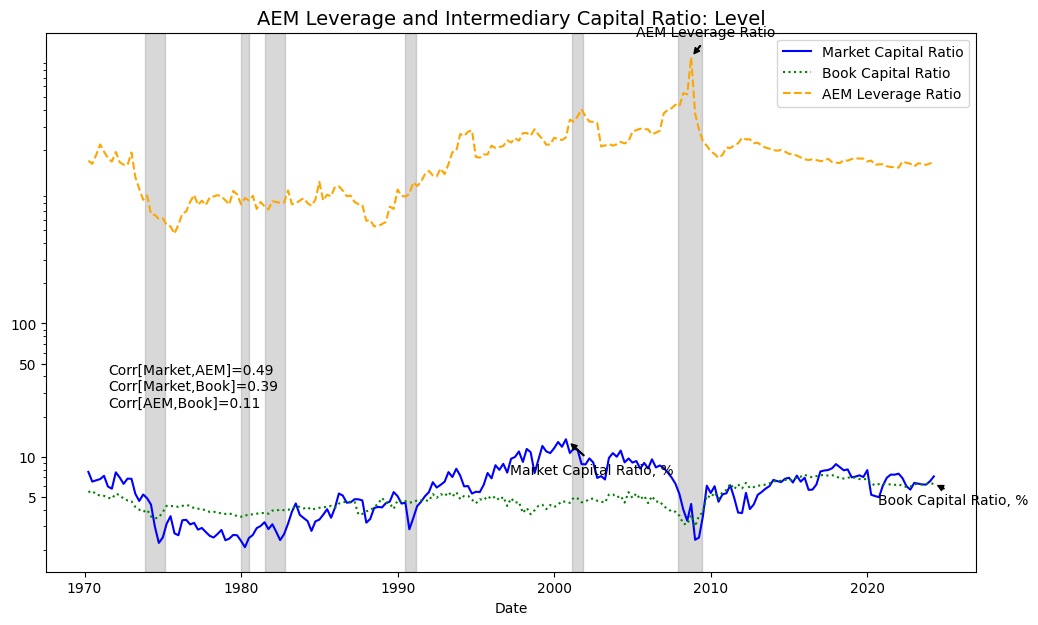

In [90]:
Table03Analysis.plot_figure02(ratio_dataset, correlation_panelA, UPDATED=False)

#### 3.6 Generate summary outputs and export to LaTeX
- We summarize our findings into tables for Panel A and B, alongside a figure that illustrates how the capital ratios have shifted over time. All time-series are standardized to zero mean and unit variance for illustration. 
- Lastly, we get our final table which was what we were trying to replicate from the original paper. This table is converted to LaTeX and outputted to a .tex file.
- Below is the figure that we created with UPDATED=True which incorporates the most recent data (also incorporating data starting from 2013). This can be compared with the 'AEM_level.png' from the authors' presentation slides.

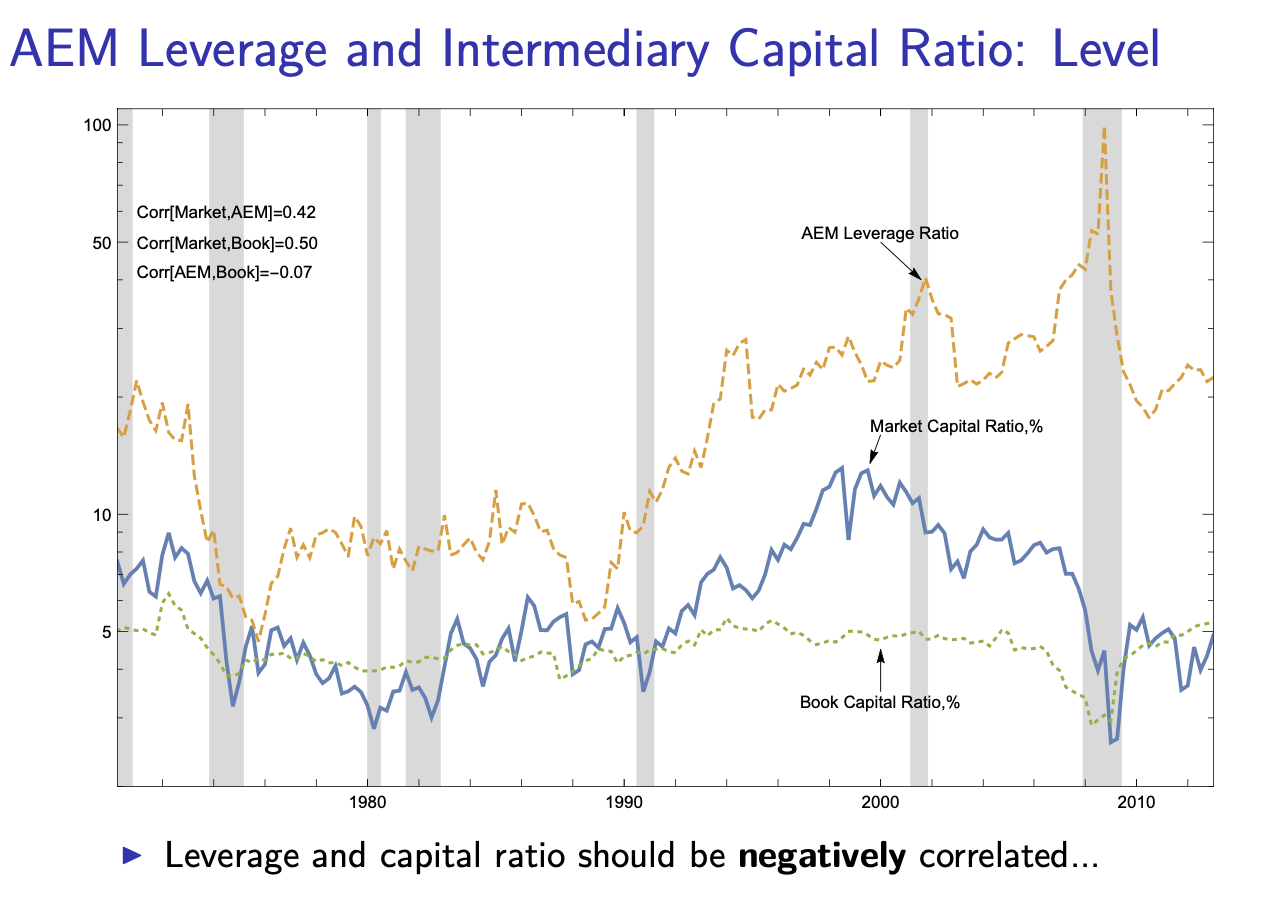

In [14]:
from IPython.display import Image
Image(filename='../data/AEM_level.png', width=800)

New Data Analysis